# Usando funções

### Função que realiza busca na internet

In [1]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

In [2]:
from langchain.agents import Tool

tool_search = Tool(
    name="search tool",
    func=serper.run,
    description="Útil para buscar coisas na internet de forma online"
)

### Função que manda mensagem no telegram

In [3]:
import requests
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

chat_id = os.getenv("TELEGRAM_CHAT_ID")
token = os.getenv("TELEGRAM_TOKEN")

def send_message(msg):
    """
    Função que manda mensagem para o telegram

    ----------
    parameters
    ----------

    msg: str
        - parâmetro contendo a mensagem que será enviada
    """
    data = {"chat_id": chat_id, "text": msg}
    url = "https://api.telegram.org/bot{}/sendMessage".format(token)
    requests.post(url, data)

In [4]:
tool_notification = Tool(
    name="tool que notifica via telegram",
    func=send_message,
    description="Função que manda mensagem para o telegram quando for pedido."
)

In [5]:
tools = [tool_search, tool_notification]

# Criando grafo

In [6]:
# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# langchain
from langchain_groq import ChatGroq

# typing
from typing import TypedDict, Annotated

# others
import gradio as gr
from IPython.display import Image, display

/home/rmede/projects/agents-course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Criando a memória para ser guardada via sqlite

In [27]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn=conn)

# Criando o estado

In [28]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Iniciando o construtor de grafo

In [29]:
graph_builder = StateGraph(State)

# Criando nó

In [30]:
llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0,
    max_tokens=300
)

llm_with_tools = llm.bind_tools(tools)

In [31]:
def chatbot_node(old_state: State) -> State:
    # Como estamos usando o typed dict ao invés de BaseModel
    response = llm_with_tools.invoke(old_state["messages"])
    return {"messages": [response]}

graph_builder.add_node("chatbot_node", chatbot_node)
graph_builder.add_node("tools_node", ToolNode(tools=tools))

# Criando edges

In [32]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
    {"tools": "tools_node", "__end__": "__end__"}
)

graph_builder.add_edge("tools_node", "chatbot_node")
graph_builder.add_edge(START, "chatbot_node")


# Compilando o grafo

In [33]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=sql_memory)

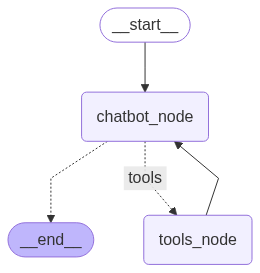

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Rodando tudo

In [36]:
config = {
    "configurable": {
        "thread_id": "1"
    }
}

# Criando função apenas para rodar no gradio

def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input
                }
            ]
        },
        config=config
    )

    print(result)
    return result["messages"][-1].content

gr.ChatInterface(fn=chat, type="messages").launch()

{'messages': [HumanMessage(content='Olá', additional_kwargs={}, response_metadata={}, id='21ec3dec-6f93-4713-816b-aa482aefa6eb'), AIMessage(content='Olá! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 737, 'total_tokens': 747, 'completion_time': 0.024233029, 'prompt_time': 0.027482081, 'queue_time': 0.292574246, 'total_time': 0.05171511}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--97d15992-a5b7-4dbd-b9a8-c467535068be-0', usage_metadata={'input_tokens': 737, 'output_tokens': 10, 'total_tokens': 747}), HumanMessage(content='Meu nome é ramon, você pdoeria ver quantos Ramons existem no Brasil e me mandar essa info via telegram?\nQuando me mandar, responda aqui tbm', additional_kwargs={}, response_metadata={}, id='78e43d1b-2ee4-43c0-9484-3eb891ca7cef'), AIMessage(content='Ol

{'messages': [HumanMessage(content='Olá, qual é o meu nome?', additional_kwargs={}, response_metadata={}, id='a9d91f55-5d0a-479a-bbd0-efc7bf3cd3bc'), AIMessage(content='Eu não tenho acesso a informações pessoais, incluindo o seu nome.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 744, 'total_tokens': 758, 'completion_time': 0.032134349, 'prompt_time': 0.023828141, 'queue_time': 0.268409916, 'total_time': 0.05596249}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--65ae3b27-46ee-458a-8007-eb295f442982-0', usage_metadata={'input_tokens': 744, 'output_tokens': 14, 'total_tokens': 758})]}
{'messages': [HumanMessage(content='Olá, qual é o meu nome?', additional_kwargs={}, response_metadata={}, id='a9d91f55-5d0a-479a-bbd0-efc7bf3cd3bc'), AIMessage(content='Eu não tenho acesso a informações pessoais, incluind

### Verificando os estados

In [38]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Olá, qual é o meu nome?', additional_kwargs={}, response_metadata={}, id='a9d91f55-5d0a-479a-bbd0-efc7bf3cd3bc'), AIMessage(content='Eu não tenho acesso a informações pessoais, incluindo o seu nome.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 744, 'total_tokens': 758, 'completion_time': 0.032134349, 'prompt_time': 0.023828141, 'queue_time': 0.268409916, 'total_time': 0.05596249}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--65ae3b27-46ee-458a-8007-eb295f442982-0', usage_metadata={'input_tokens': 744, 'output_tokens': 14, 'total_tokens': 758}), HumanMessage(content='Meu nome é ramon, muito prazer', additional_kwargs={}, response_metadata={}, id='cd2637d1-fd2a-455d-ba7c-547fa6e4258d'), AIMessage(content='Muito prazer, Ramon! É um prazer conver

### Verificando os passos da conversa

In [39]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Olá, qual é o meu nome?', additional_kwargs={}, response_metadata={}, id='a9d91f55-5d0a-479a-bbd0-efc7bf3cd3bc'), AIMessage(content='Eu não tenho acesso a informações pessoais, incluindo o seu nome.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 744, 'total_tokens': 758, 'completion_time': 0.032134349, 'prompt_time': 0.023828141, 'queue_time': 0.268409916, 'total_time': 0.05596249}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--65ae3b27-46ee-458a-8007-eb295f442982-0', usage_metadata={'input_tokens': 744, 'output_tokens': 14, 'total_tokens': 758}), HumanMessage(content='Meu nome é ramon, muito prazer', additional_kwargs={}, response_metadata={}, id='cd2637d1-fd2a-455d-ba7c-547fa6e4258d'), AIMessage(content='Muito prazer, Ramon! É um prazer conve

# Abrindo o arquivo

In [46]:
import pandas as pd

conn = sqlite3.connect('memory.db')

query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
print(tables)

          name
0  checkpoints
1       writes


In [48]:
checkpoints_df = pd.read_sql_query("SELECT * FROM checkpoints;", conn)
writes_df = pd.read_sql_query("SELECT * FROM writes;", conn)

In [50]:
checkpoints_df.head()

,thread_id,checkpoint_ns,checkpoint_id,parent_checkpoint_id,type,checkpoint,metadata
0,029qry8fshdn932,,1f077b47-d925-6a5b-bfff-9755582335c5,None,msgpack,b'\x87\xa1v\x04\xa2ts\xd9 2025-08-12T19:42:33....,"b'{""source"": ""input"", ""step"": -1, ""parents"": {}}'"
1,029qry8fshdn932,,1f077b47-d929-61ab-8000-f0d032b2eb00,1f077b47-d925-6a5b-bfff-9755582335c5,msgpack,b'\x87\xa1v\x04\xa2ts\xd9 2025-08-12T19:42:33....,"b'{""source"": ""loop"", ""step"": 0, ""parents"": {}}'"
2,029qry8fshdn932,,1f077b47-e056-6a8b-8001-7ffdc5139831,1f077b47-d929-61ab-8000-f0d032b2eb00,msgpack,b'\x87\xa1v\x04\xa2ts\xd9 2025-08-12T19:42:34....,"b'{""source"": ""loop"", ""step"": 1, ""parents"": {}}'"
3,029qry8fshdn932,,1f077b49-0796-6c8a-8002-40a9bb80740e,1f077b47-e056-6a8b-8001-7ffdc5139831,msgpack,b'\x87\xa1v\x04\xa2ts\xd9 2025-08-12T19:43:05....,"b'{""source"": ""input"", ""step"": 2, ""parents"": {}}'"
4,029qry8fshdn932,,1f077b49-0799-6e86-8003-20794edca951,1f077b49-0796-6c8a-8002-40a9bb80740e,msgpack,b'\x87\xa1v\x04\xa2ts\xd9 2025-08-12T19:43:05....,"b'{""source"": ""loop"", ""step"": 3, ""parents"": {}}'"


In [51]:
writes_df.head()

,thread_id,checkpoint_ns,checkpoint_id,task_id,idx,channel,type,value
0,029qry8fshdn932,,1f077b47-d925-6a5b-bfff-9755582335c5,58690747-f5ee-7c3e-9da6-84f1dc368d6e,0,messages,msgpack,b'\x91\x82\xa4role\xa4user\xa7content\xa4Ol\xc...
1,029qry8fshdn932,,1f077b47-d925-6a5b-bfff-9755582335c5,58690747-f5ee-7c3e-9da6-84f1dc368d6e,1,branch:to:chatbot_node,null,b''
2,029qry8fshdn932,,1f077b47-d929-61ab-8000-f0d032b2eb00,a5fa6026-5c49-8946-53d1-d3c70b9dfd9c,0,messages,msgpack,b'\x91\xc8\x02V\x05\x94\xbalangchain_core.mess...
3,029qry8fshdn932,,1f077b49-0796-6c8a-8002-40a9bb80740e,740408e1-d91d-1473-c55b-2be43245df25,0,messages,msgpack,b'\x91\x82\xa4role\xa4user\xa7content\xd9\x8dM...
4,029qry8fshdn932,,1f077b49-0796-6c8a-8002-40a9bb80740e,740408e1-d91d-1473-c55b-2be43245df25,1,branch:to:chatbot_node,null,b''
